In [104]:
import pandas as pd
from math import radians, sin, cos, sqrt, atan2
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque

#### Funções para o cálculo de distância entre uma estação e outra no DataFrame

In [105]:
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0 * 1000

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return round(distance, 2)


def get_station_info(station_name, df):
    station_rows = df[df["Station"] == station_name]
    if not station_rows.empty:
        station_info = {
            "Latitude": station_rows.iloc[0]["Latitude"],
            "Longitude": station_rows.iloc[0]["Longitude"],
            "Lines": set(station_rows["Line"]),
        }
        return station_info
    else:
        return None


def calculate_distance(row, df):
    origin_info = get_station_info(row["Station"], df)
    dest_info = get_station_info(row["Destination"], df)

    if origin_info and dest_info:
        if origin_info["Lines"].intersection(dest_info["Lines"]):
            return haversine_distance(
                origin_info["Latitude"],
                origin_info["Longitude"],
                dest_info["Latitude"],
                dest_info["Longitude"],
            )
    return None

#### Formatações do Dataframe

In [106]:
df = pd.read_csv("Metro_Madrid_2021.csv")
df = df.drop("Traffic", axis=1)
df["Longitude"] = df["Longitude"].str.replace(",", ".").astype(float)
df["Latitude"] = df["Latitude"].str.replace(",", ".").astype(float)
df.insert(1, "Destination", df["Station"].shift(-1))
df.insert(2, "Distance", df.apply(lambda row: calculate_distance(row, df), axis=1))
df = df.dropna(subset=["Distance"])
df.drop(df.loc[df["Distance"] > 5000].index, inplace=True)
new_rows = df.copy()
new_rows.rename(
    columns={"Station": "Destination", "Destination": "Station"}, inplace=True
)
df = pd.concat([df, new_rows], ignore_index=True)

In [107]:
df.head()

,Station,Destination,Distance,Line,Order of Points,Longitude,Latitude
0,Pinar de Chamartin,Bambú,867.28,Linea 1,1,-3.667061,40.480136
1,Bambú,Chamartín,754.71,Linea 1,2,-3.676374,40.476872
2,Chamartín,Plaza de Castilla,799.03,Linea 1,3,-3.682768,40.472138
3,Plaza de Castilla,Valdeacederas,573.41,Linea 1,4,-3.689163,40.466849
4,Valdeacederas,Tetuán,422.98,Linea 1,5,-3.695128,40.464401


#### Criação do grafo

In [108]:
graph_df = df[["Station", "Destination", "Distance"]]
graph_df = graph_df.dropna()

In [109]:
graph = {}
#Colocando todos dos dados do DataFrame em um Dict
for row in df.itertuples():
    station = row.Station
    destination = row.Destination
    distance = row.Distance

    if pd.isna(distance):
        continue

    if station not in graph:
        graph[station] = []

    graph[station].append((destination, distance))

In [110]:
print(graph)

{'Pinar de Chamartin': [('Bambú', 867.28)], 'Bambú': [('Chamartín', 754.71), ('Pinar de Chamartin', 867.28)], 'Chamartín': [('Plaza de Castilla', 799.03), ('Plaza de Castilla', 799.03), ('Bambú', 754.71), ('Begoña', 960.32)], 'Plaza de Castilla': [('Valdeacederas', 573.41), ('Duque de Pastrana', 831.37), ('Cuzco', 956.24), ('Chamartín', 799.03), ('Ventilla', 644.52), ('Chamartín', 799.03)], 'Valdeacederas': [('Tetuán', 422.98), ('Plaza de Castilla', 573.41)], 'Tetuán': [('Estrecho', 847.13), ('Valdeacederas', 422.98)], 'Estrecho': [('Alvarado', 489.39), ('Tetuán', 847.13)], 'Alvarado': [('Cuatro Caminos', 358.11), ('Estrecho', 489.39)], 'Cuatro Caminos': [('Ríos Rosas', 661.5), ('Moncloa', 1887.53), ('Nuevos Ministerios', 1015.86), ('Alvarado', 358.11), ('Canal', 978.11), ('Guzmán el Bueno', 664.78)], 'Ríos Rosas': [('Iglesia', 755.09), ('Cuatro Caminos', 661.5)], 'Iglesia': [('Bilbao', 714.56), ('Ríos Rosas', 755.09)], 'Bilbao': [('Tribunal', 334.98), ('Alonso Martínez', 552.57), ('Ig

## Breadth First Search (largura)

In [111]:
def bfs(graph, start_station, destination, nodes_explored):
    queue = deque([(start_station, [start_station])])
    visited = set()

    while queue:
        current_station, path = queue.popleft()
        nodes_explored += 1

        if current_station == destination:
            return path, nodes_explored

        visited.add(current_station)

        # Use o dicionário para obter os vizinhos
        adjacents = graph.get(current_station, [])
        for adjacent, _ in adjacents:
            if adjacent not in visited:
                visited.add(adjacent)
                queue.append((adjacent, path + [adjacent]))

    return None, nodes_explored

In [112]:
start = "Pitis"
end = "Valdecarros"
nodes_explored = 0

path, nodes_explored = bfs(graph, start, end, nodes_explored)

print("Caminho encontrado:", path)
print("Número total de nós explorados:", nodes_explored)

Caminho encontrado: ['Pitis', 'Arroyofresno', 'Lacoma', 'Avenida de la Ilustración', 'Peñagrande', 'Antonio Machado', 'Valdezarza', 'Francos Rodríguez', 'Guzmán el Bueno', 'Cuatro Caminos', 'Nuevos Ministerios', 'República Argentina', 'Avenida de América\t', 'Diego de León', 'Manuel Becerra', "O'Donnell", 'Sainz de Baranda', 'Conde de Casal', 'Pacífico', 'Puente de Vallecas', 'Nueva Numancia', 'Portazgo', 'Buenos Aires', 'Alto del Arenal', 'Miguel Hernández', 'Sierra de Guadalupe\t', 'Villa de Vallecas', 'Congosto', 'La Gavia', 'Las Suertes', 'Valdecarros']
Número total de nós explorados: 229


In [113]:
def total_distance(graph_df, path, start):
    distance = 0
    for i in path[1:]:
        distance += graph_df[(graph_df["Station"] == start) & (graph_df["Destination"] == i)]["Distance"].iloc[0]
        start = i
    return round(distance, 2)

In [114]:
distance = total_distance(graph_df, path, start)
print(distance)

22052.49


In [115]:
def visualize_graph(graph_dict, df, path=None):
    # Criando o grafo NetworkX a partir do dicionário
    G = nx.Graph()
    for station, adjacents in graph_dict.items():
        for destination, distance in adjacents:
            G.add_edge(station, destination, weight=distance)

    # Adicionando posições ao grafo
    pos = {
        row["Station"]: (row["Longitude"], row["Latitude"])
        for idx, row in df.iterrows()
    }

    plt.figure(figsize=(20, 15))

    # Desenha os nós e arestas com estilo básico
    nx.draw(G, pos, node_size=50, node_color="blue", edge_color="gray", alpha=0.5)

    # Desenha o caminho com um estilo diferente, se existir
    if path:
        path_edges = list(zip(path, path[1:]))
        nx.draw_networkx_nodes(G, pos, nodelist=path, node_size=100, node_color="red")
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color="red", width=2)
        # Cria rótulos apenas para os nós do caminho
        labels = {node: node for node in path}
        nx.draw_networkx_labels(G, pos, labels=labels, font_size=5)

    plt.title("Mapa do Metrô de Madrid com Caminho A*")
    plt.axis("off")
    plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


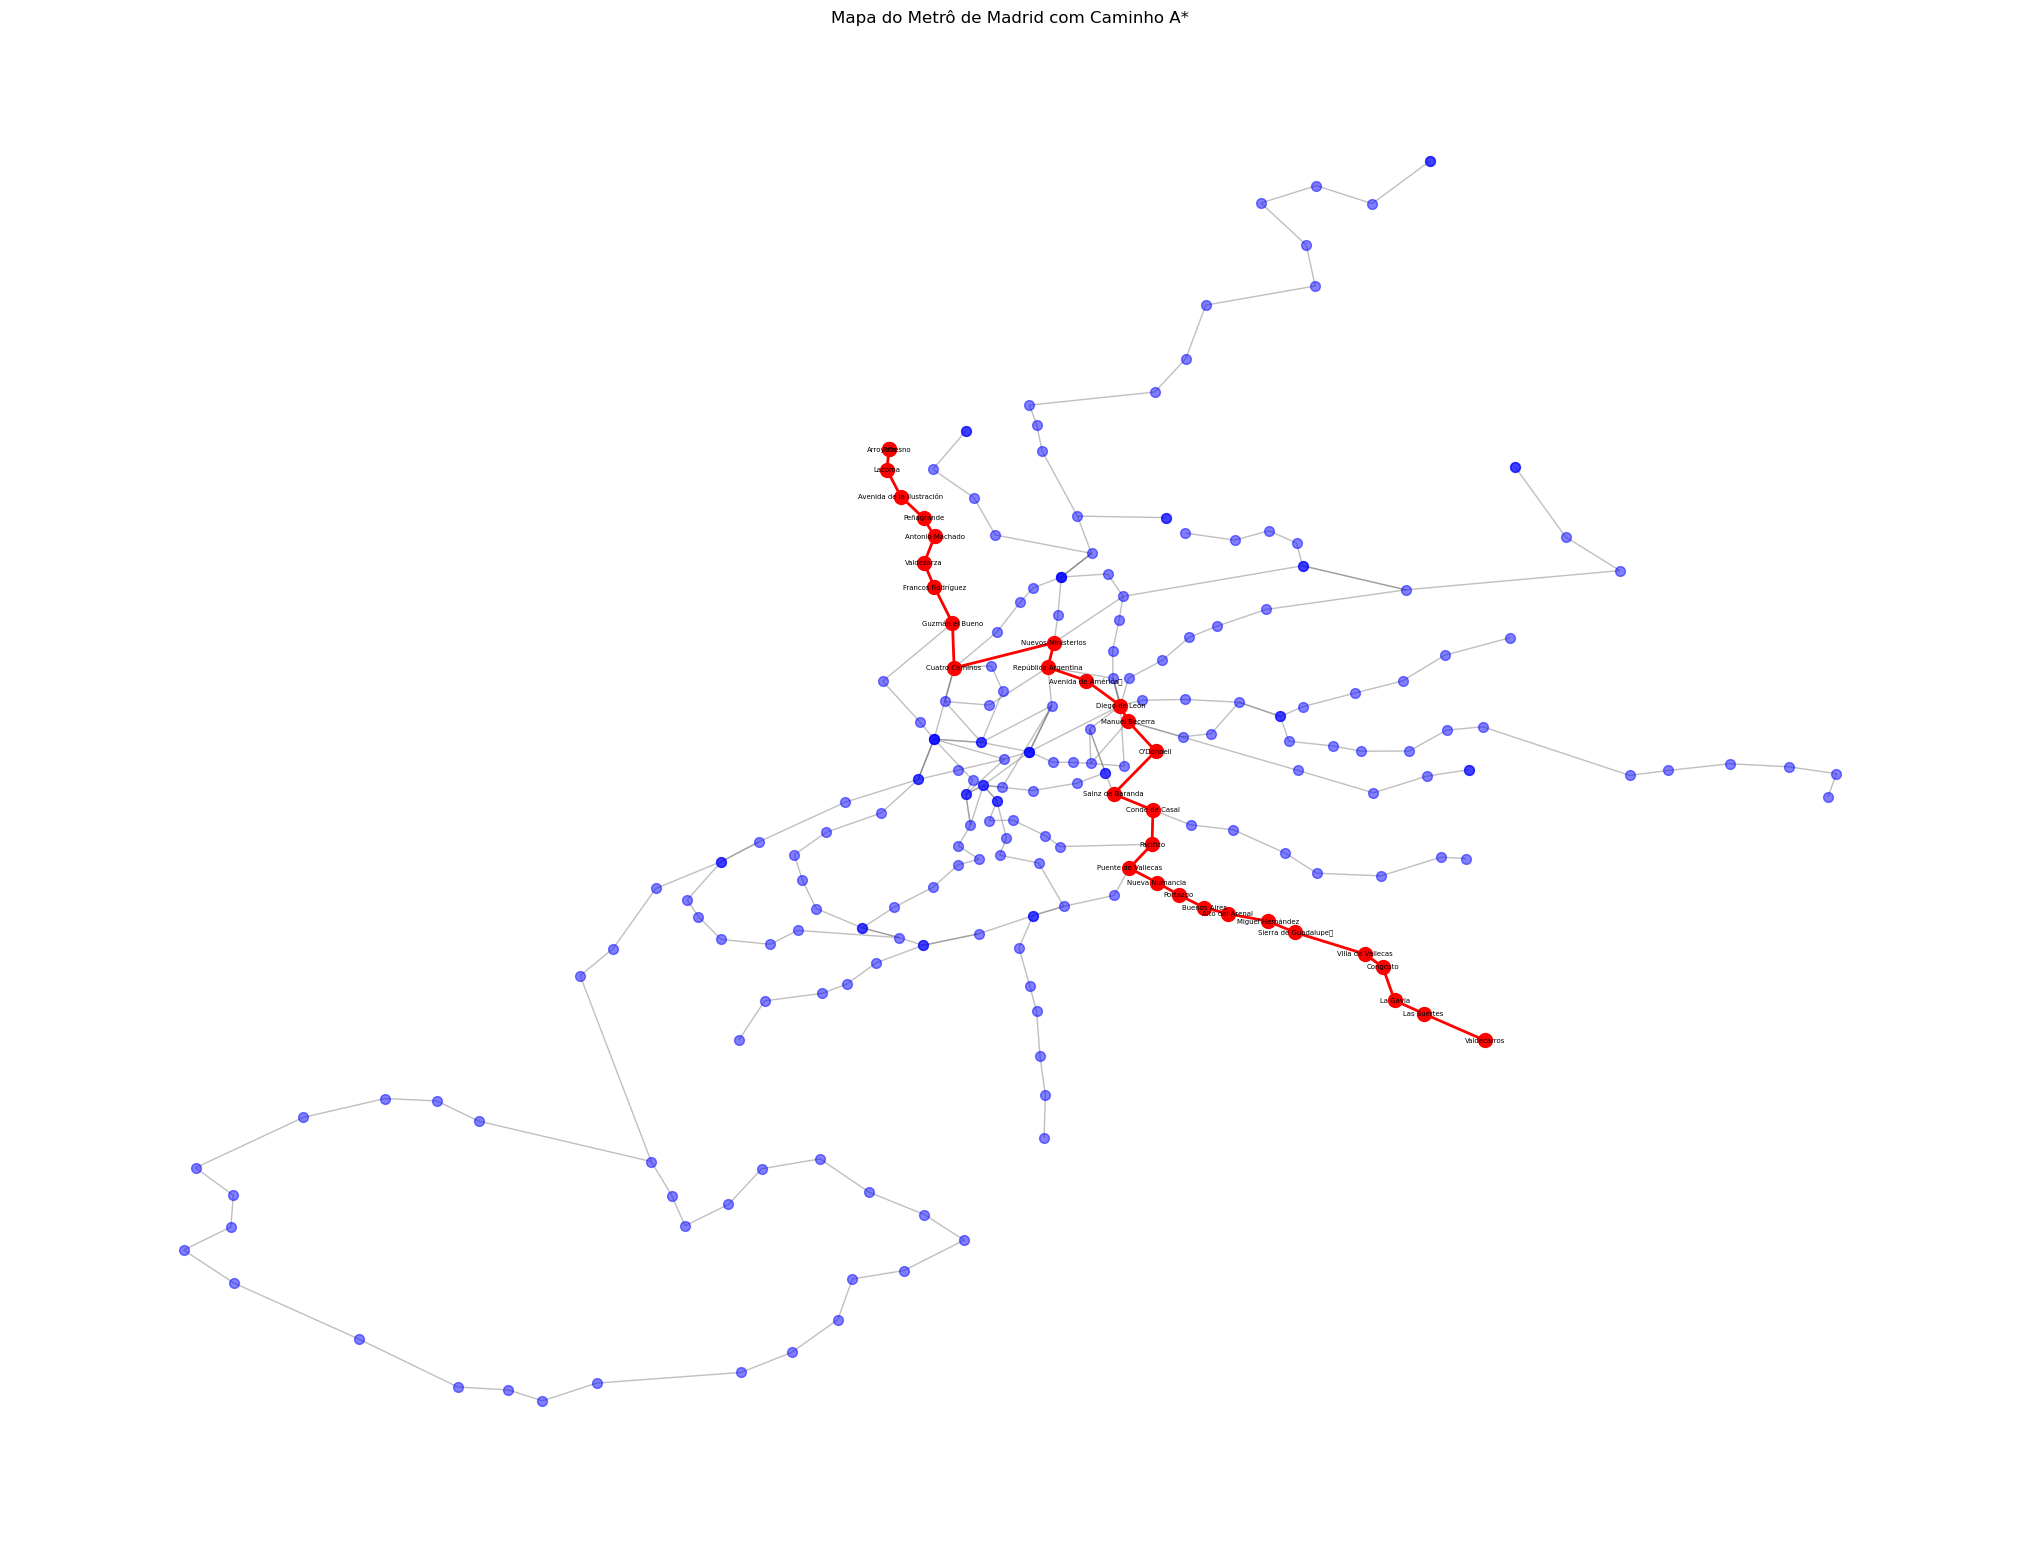

In [116]:
visualize_graph(graph, df, path)